In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from getdist import MCSamples, plots
basedir = os.path.dirname(os.path.abspath(''))
sourcedir = os.path.join(basedir, 'source')
import sys
sys.path.insert(0, sourcedir)
from mcmc import MCMC

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

#################################################
# Function defs
#################################################

names = ["$\Omega_m$", "$\Omega_{\Lambda}$", "$H_0$", "$M$" ]

def make_trace_plot(chains, labels=names, ylims=[[0,1], [0,1], [50,100], [-25,-15]]):
    fig,ax=plt.subplots(4,1, figsize=(8, 10))
    for chain in chains:
        for i in np.arange(4):
            ax[i].plot(chain[:,i])
            ax[i].set_ylim(ylims[i])
            ax[i].set_ylabel(labels[i], fontsize=14)
    return fig,ax



#################################################
# Directory setup
#################################################

datadir = os.path.join(basedir, 'data')
binned_data_file = os.path.join(datadir, 'lcparam_DS17f.txt')
binned_sys_file = os.path.join(datadir, 'sys_DS17f.txt')

# With Systematics

## Initial chain to estimate generating function covariance

Below we run a shorter chain to get a rough estimate of the covariance between parameters. This will then be used to run a longer chain for actual parameter estimates.

In [2]:

start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
g_cov = np.diag([.01, .01, .1, .01])

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=binned_sys_file, 
                    g_cov=g_cov)

markov_chain.make_chain(10000)

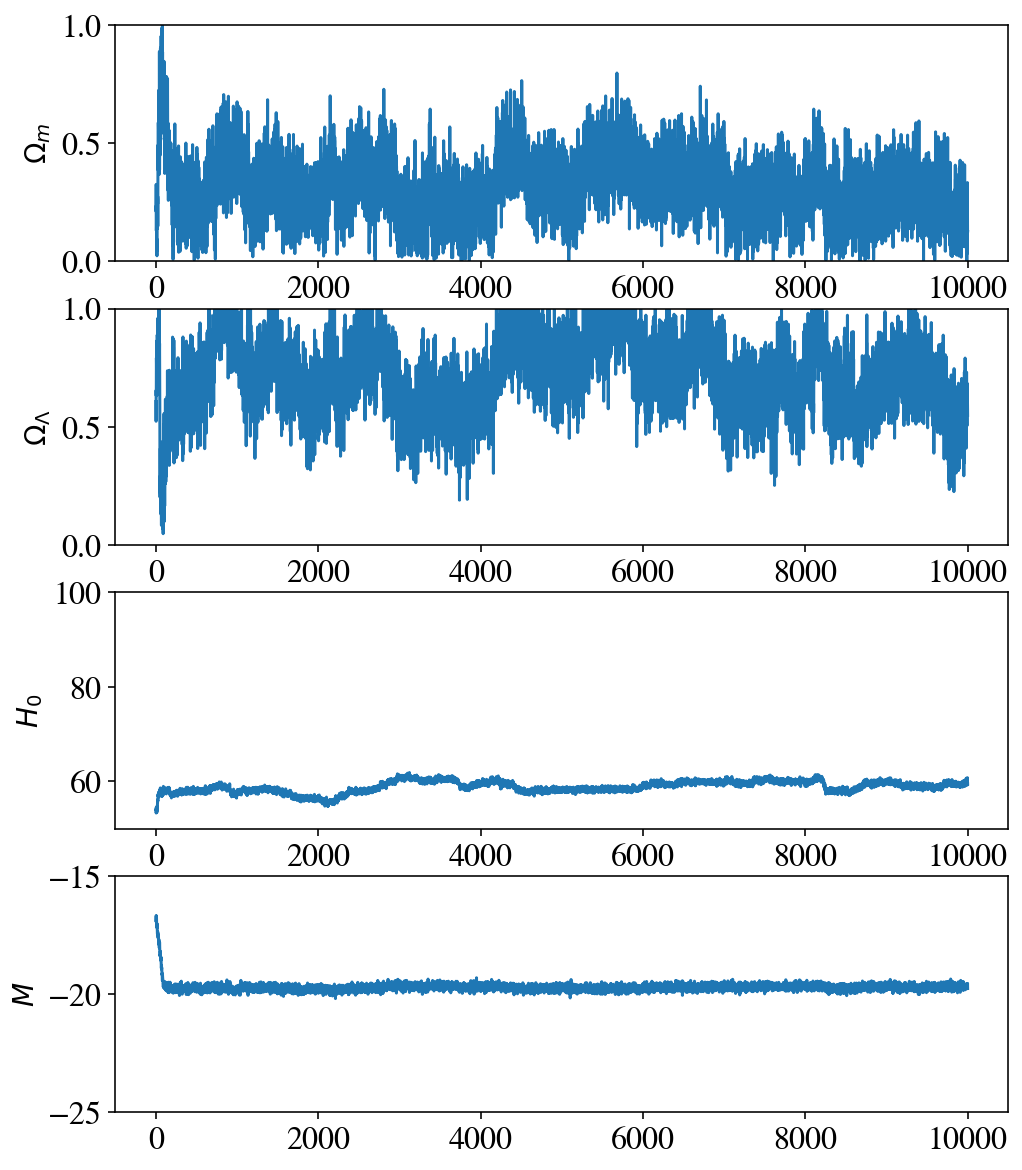

In [3]:
chains = []
chains.append(markov_chain.chain)
fig,ax= make_trace_plot(chains)
plt.show()

Now we use the above chains to estimate the parameter covariance, which will be used to refine the generating function on the next run.

In [4]:
burn_in = 500
cov = np.cov(markov_chain.chain[burn_in:, :].T)
alpha= .1
cov*=alpha
print(cov)

[[ 1.54845519e-03  8.81529754e-04 -1.65772967e-03 -1.09502219e-04]
 [ 8.81529754e-04  2.53090203e-03 -3.03622302e-03 -2.43347640e-04]
 [-1.65772967e-03 -3.03622302e-03  1.40343061e-01  5.07203389e-03]
 [-1.09502219e-04 -2.43347640e-04  5.07203389e-03  1.20455691e-03]]


In [5]:
start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=binned_sys_file, 
                    g_cov=cov)

markov_chain.make_chain(50000)

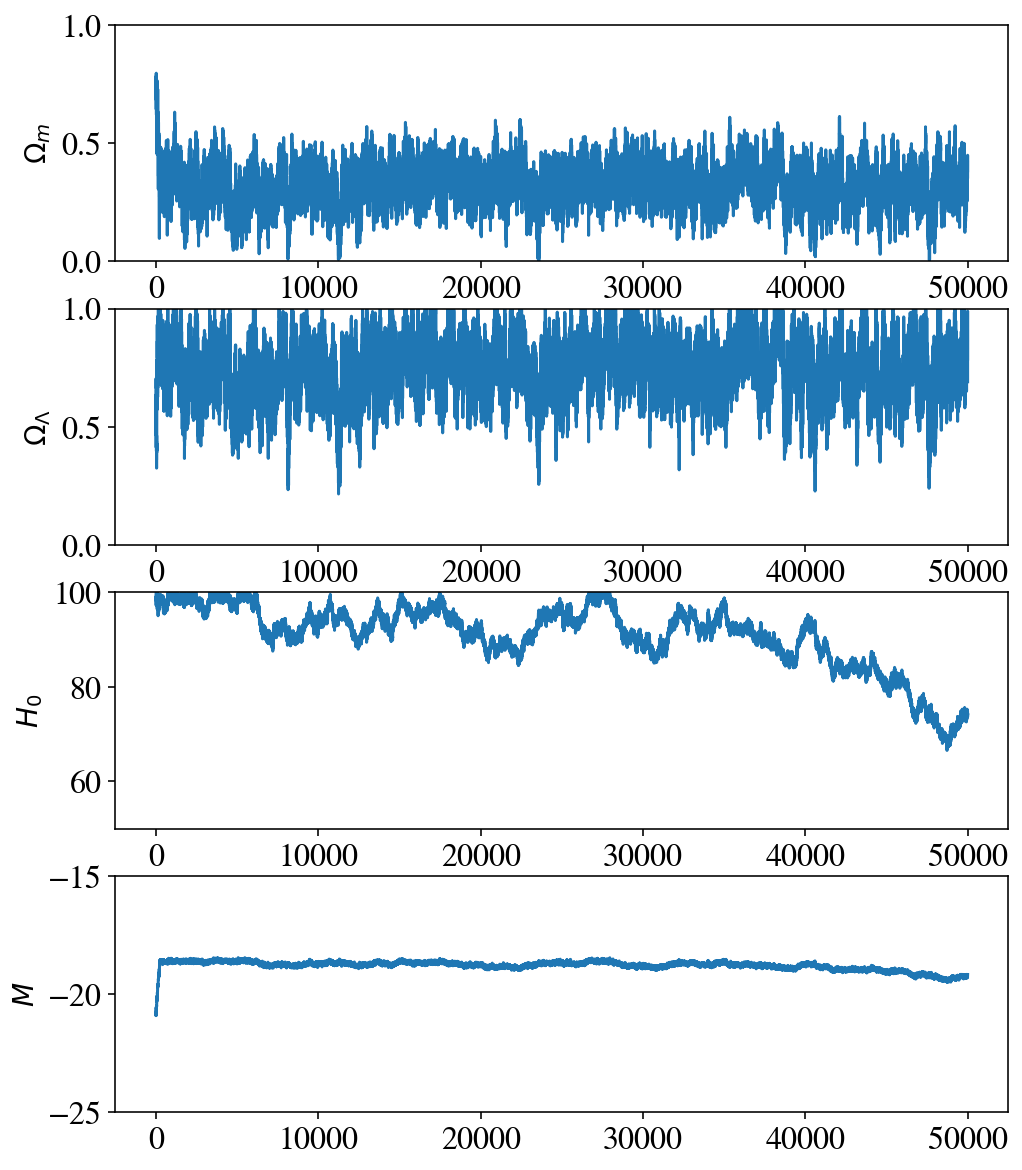

In [6]:
chains = []
chains.append(markov_chain.chain)
fig,ax= make_trace_plot(chains)
plt.show()

# Without Systematics

In [7]:
start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
g_cov = np.diag([.01, .01, .1, .01])

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=None, 
                    g_cov=g_cov)

markov_chain.make_chain(10000)

burn_in = 500
cov = np.cov(markov_chain.chain[burn_in:, :].T)
alpha= .1
cov*=alpha
print(cov)

start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=None, 
                    g_cov=cov)

markov_chain.make_chain(50000)

chains.append(markov_chain.chain)

[[ 1.16181660e-03  2.23670711e-04 -3.64498241e-05 -2.01326308e-05]
 [ 2.23670711e-04  1.42386246e-03  2.59420971e-04 -5.23071380e-05]
 [-3.64498241e-05  2.59420971e-04  7.52177530e-02  2.08342315e-03]
 [-2.01326308e-05 -5.23071380e-05  2.08342315e-03  1.09473798e-03]]


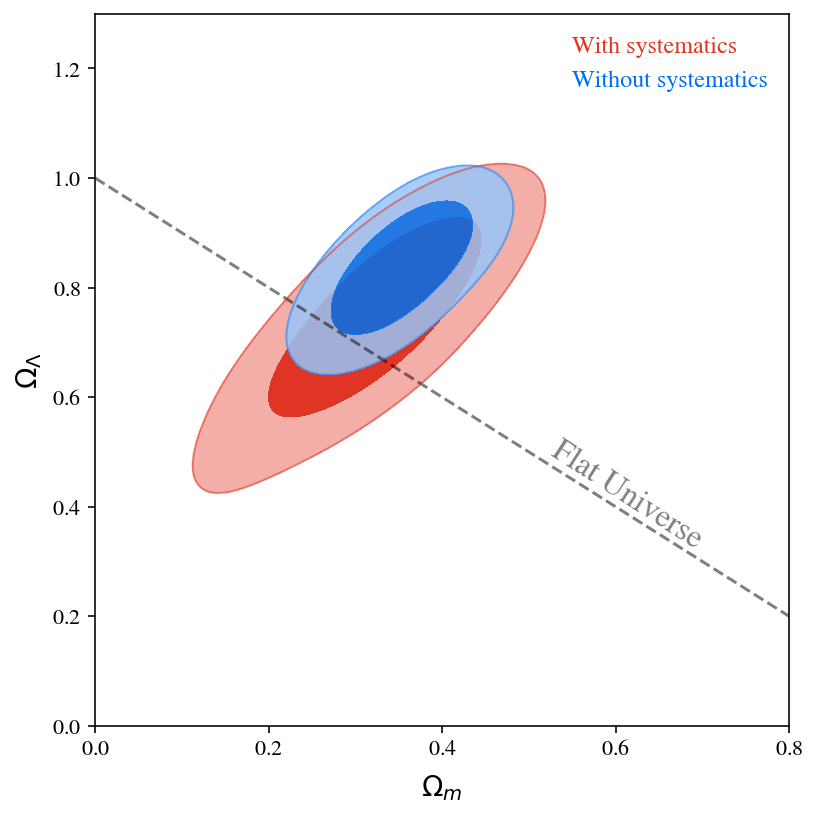

In [9]:
burn_in = 1000
p_names = ['Om', 'Ol', "H0", "M"]
p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]
sys_samples = MCSamples(samples=chains[0],names = p_names, labels = p_labels, ignore_rows=burn_in)
no_sys_samples = MCSamples(samples=chains[1],names = p_names, labels = p_labels, ignore_rows=burn_in)

sys_samples.updateSettings({'contours': [0.68, 0.95]})
no_sys_samples.updateSettings({'contours': [0.68, 0.95]})
om_grid = np.linspace(0,1,100)
g = plots.get_single_plotter(width_inch=6, ratio=1. / 1)
g.get_axes().plot(om_grid, -om_grid+1, linestyle="dashed", color="k", alpha=0.5)
g.get_axes().text(0.65, 0.25, 'Flat Universe', rotation=-33, alpha=0.5, transform=g.get_axes().transAxes)
g.plot_2d([sys_samples, no_sys_samples], p_names[0], p_names[1], filled=True, lims=[0, 0.8, 0, 1.3])


g.add_legend(['With systematics', 'Without systematics'], colored_text=True)

In [ ]:
resultsdir = os.path.join(basedir, 'results')
out_name = os.path.join(resultsdir, "omega_contour_plot.pdf")

save_plot = False
if(save_plot):
    g.export(fname=out_name)

# Constraints on $H_0$


In [18]:
#start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), np.random.uniform(-25, -15)]
start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), -19.15]

g_cov = np.diag([.01, .01, .1, .01])

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=binned_sys_file, 
                    g_cov=g_cov,
                    M_gaussian_prior = True)

markov_chain.make_chain(10000)

burn_in = 500
cov = np.cov(markov_chain.chain[burn_in:, :].T)
alpha= .1
cov*=alpha
print(cov)

start = [np.random.uniform(0, 1), np.random.uniform(0,1), np.random.uniform(50,100), -19.15]

markov_chain = MCMC(initial_state=start,
                    data_file=binned_data_file,
                    systematics_file=binned_sys_file, 
                    g_cov=cov,
                    M_gaussian_prior = True)

markov_chain.make_chain(50000)

[[ 1.07740759e-03 -1.60185287e-04 -1.10247925e-03  5.41759941e-05]
 [-1.60185287e-04  1.54109929e-03  2.47442294e-03 -9.92105087e-05]
 [-1.10247925e-03  2.47442294e-03  2.43009117e-02 -5.38884385e-04]
 [ 5.41759941e-05 -9.92105087e-05 -5.38884385e-04  1.02291190e-03]]


In [19]:
print(markov_chain.chain)

[[  0.22021054   0.95370112  72.33745246 -19.15      ]
 [  0.20288791   1.03987951  72.76635115 -19.1996683 ]
 [  0.26387081   0.939427    72.08485614 -19.15091566]
 ...
 [  0.37117891   0.7403205   73.55958472 -19.24293419]
 [  0.34281746   0.71417392  73.48845514 -19.17277808]
 [  0.33314892   0.74023414  73.48140699 -19.2751638 ]]


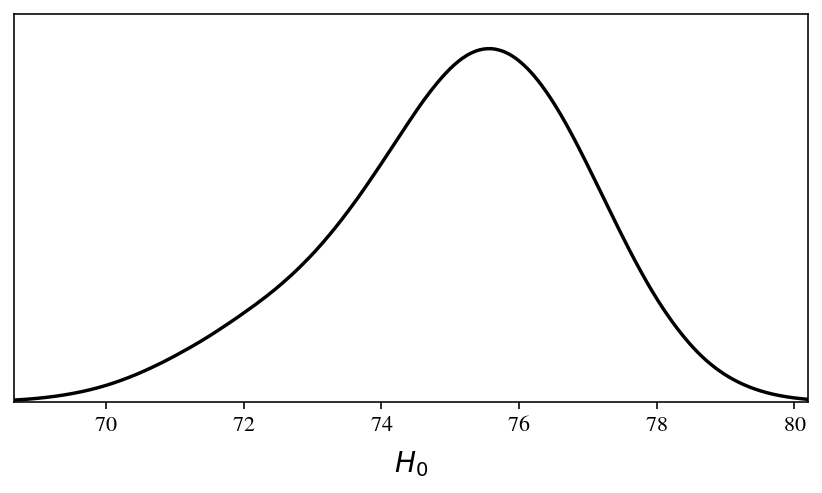

In [20]:
burn_in = 1000
p_names = ['Om', 'Ol', "H0", "M"]
p_labels = ['\Omega_m', '\Omega_\Lambda', "H_0", "M"]
H0_samples = MCSamples(samples=markov_chain.chain ,names = p_names, labels = p_labels, ignore_rows=burn_in)

g = plots.get_single_plotter(width_inch=6, ratio=1. / 1.6)
g.plot_1d(H0_samples, p_names[2])